In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd
from scipy import stats
from pingouin import sphericity

In [2]:
df = pd.read_csv('./DataSheet_Thesis.csv')

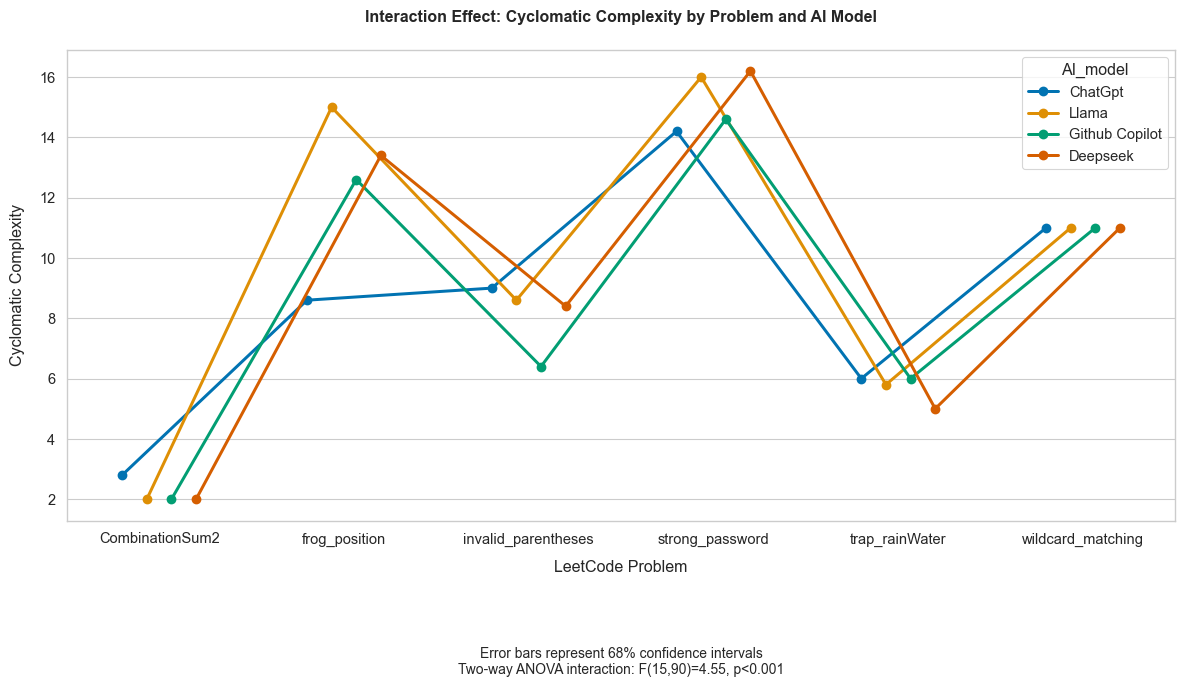

In [3]:
# Set style and context
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)  # Larger font

# Create the plot
plt.figure(figsize=(12, 6))
ax = sns.pointplot(
    x='Problems',
    y='Cyclomatic',
    hue='AI_model',
    data=df,
    errorbar=None,  # 68% CI (~1 SE) for tighter error bars
    palette="colorblind",  # Color-safe palette
    dodge=0.4,  # Separate points for each model
)

# Enhancements
plt.title("Interaction Effect: Cyclomatic Complexity by Problem and AI Model", pad=20, fontweight='bold')
plt.xlabel("LeetCode Problem", labelpad=10)
plt.ylabel("Cyclomatic Complexity", labelpad=10)

# Adjust layout
plt.tight_layout()  # Prevent label cutoff

# Add statistical notation
plt.text(
    0.5, -0.3,  # Position below x-axis
    "Error bars represent 68% confidence intervals\nTwo-way ANOVA interaction: F(15,90)=4.55, p<0.001",
    ha='center',
    va='center',
    transform=ax.transAxes,
    fontsize=10
)
plt.savefig('cyclomatic_by_problem.png', dpi=300, bbox_inches='tight')
plt.show()

In [4]:
# Load and clean the data
def load_and_clean_data(filepath):
    """
    Load the CSV file and perform initial cleaning:
    - Remove rows with missing metric values
    - Convert numeric columns to appropriate types
    - Standardize column names
    """
    df = pd.read_csv(filepath)

    # Clean column names
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

    # Select only relevant columns for analysis
    metrics = ['ai_model', 'problems', 'loc', 'cyclomatic', 'halstead', 'maintainability', 'correctnes', 'timecomplexity', 'spacecomplexity', 'solution']
    df = df[metrics]

    # Drop rows where any metric is missing
    df = df.dropna()

    # Convert numeric columns (some might be read as objects)
    numeric_cols = ['loc', 'cyclomatic', 'halstead', 'maintainability']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

    return df

In [5]:
# Check ANOVA assumptions
def check_assumptions(data, metric, group_col='ai_model'):
    """
    Check the three main ANOVA assumptions:
    1. Normality (Shapiro-Wilk test)
    2. Homogeneity of variance (Levene's test)
    3. Sphericity (for repeated measures)
    """
    print(f"\n=== Checking Assumptions for {metric} ===")

    # 1. Normality (check residuals)
    model = ols(f'{metric} ~ C({group_col})', data=data).fit()
    _, p_norm = stats.shapiro(model.resid)
    print(f"Normality (Shapiro-Wilk) p-value: {p_norm:.4f}")
    print("-> Assumption met" if p_norm > 0.05 else "-> WARNING: Normality violated")

    # 2. Homogeneity of variance
    groups = [data[data[group_col] == group][metric] for group in data[group_col].unique()]
    _, p_homog = stats.levene(*groups)
    print(f"Homogeneity (Levene's) p-value: {p_homog:.4f}")
    print("-> Assumption met" if p_homog > 0.05 else "-> WARNING: Variance not homogeneous")

    # 3. Sphericity (only needed for repeated measures)
    if 'problems' in data.columns:
        try:
            spher_test = sphericity(data, dv=metric, within='problems', subject='ai_model')
            print(f"Sphericity (Mauchly's) p-value: {spher_test[1]:.4f}")
            print("-> Assumption met" if spher_test[1] > 0.05 else "-> WARNING: Sphericity violated")
        except:
            print("Could not calculate sphericity - may not be applicable")

    return p_norm > 0.05 and p_homog > 0.05

In [6]:
# Perform one-way ANOVA
def one_way_anova(data, metric, group_col='ai_model'):
    """
    Perform one-way ANOVA for a given metric across groups.
    Includes assumption checking and post-hoc tests if significant.
    """

    # Check assumptions first
    assumptions_met = check_assumptions(data, metric, group_col)

    # Perform ANOVA
    model = ols(f'{metric} ~ C({group_col})', data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"\n=== One-Way ANOVA Results for {metric} ===")
    print("\nANOVA Table-----:")
    print(anova_table)

    # Calculate effect size (eta squared)
    eta_sq = anova_table['sum_sq'][0] / (anova_table['sum_sq'][0] + anova_table['sum_sq'][1])
    print(f"\nEffect Size (η²): {eta_sq:.3f}")

    # If significant, perform post-hoc tests
    if anova_table['PR(>F)'][0] < 0.05:
        print("\nSignificant difference found - running post-hoc Tukey HSD...")
        tukey = pairwise_tukeyhsd(data[metric], data[group_col])
        print(tukey.summary())

        # Visualize group differences
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=group_col, y=metric, data=data)
        plt.title(f'Distribution of {metric} by {group_col}')
        plt.savefig(f'distibution_{metric}_by_ai.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("\nNo significant differences found between groups.")

    return anova_table

In [7]:
# Perform two-way ANOVA (AI Model × Problem)
def two_way_anova(data, metric):
    """
    Perform two-way ANOVA to examine:
    - Main effect of AI Model
    - Main effect of Problem
    - Interaction effect between AI Model and Problem
    """
    print(f"\n=== Two-Way ANOVA Results for {metric} ===")

    # Fit the model
    model = ols(f'{metric} ~ C(ai_model) + C(problems) + C(ai_model):C(problems)', data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("\nANOVA Table:")
    print(anova_table)

    # Calculate effect sizes
    total_ss = anova_table['sum_sq'].sum()
    for effect in anova_table.index:
        eta_sq = anova_table.loc[effect, 'sum_sq'] / total_ss
        print(f"\nEffect Size for {effect} (η²): {eta_sq:.3f}")

    return anova_table

In [8]:
# Load and clean data
df = load_and_clean_data('./DataSheet_Thesis.csv')

# Analyze each metric
metrics = ['loc', 'cyclomatic', 'halstead', 'maintainability']
# One-way ANOVA (AI Model effect)
print(f"\n{'='*50}")
print(f"ANALYZING METRIC: LOC")
print(f"{'='*50}")
one_way_anova(df, 'loc')



ANALYZING METRIC: LOC

=== Checking Assumptions for loc ===
Normality (Shapiro-Wilk) p-value: 0.0000
-> WARNING: Normality violated
Homogeneity (Levene's) p-value: 0.1201
-> Assumption met
Sphericity (Mauchly's) p-value: 0.0182
-> WARNING: Sphericity violated

=== One-Way ANOVA Results for loc ===

ANOVA Table-----:
                  sum_sq    df         F    PR(>F)
C(ai_model)   255.027778   3.0  1.232891  0.305381
Residual     4274.972222  62.0       NaN       NaN

Effect Size (η²): 0.056

No significant differences found between groups.


C:\Users\rgont\AppData\Local\Temp\ipykernel_1584\1064116566.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eta_sq = anova_table['sum_sq'][0] / (anova_table['sum_sq'][0] + anova_table['sum_sq'][1])
C:\Users\rgont\AppData\Local\Temp\ipykernel_1584\1064116566.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table['PR(>F)'][0] < 0.05:


,sum_sq,df,F,PR(>F)
C(ai_model),255.027778,3.0,1.232891,0.305381
Residual,4274.972222,62.0,NaN,NaN


In [9]:
from scipy.stats import kruskal
# For Normality Violation:
# Use Non-Parametric Alternative:

groups = [df[df['ai_model']==model]['loc'] 
          for model in df['ai_model'].unique()]
h_stat, p_val = kruskal(*groups)
print(f"Kruskal-Wallis H = {h_stat:.3f}, p = {p_val:.3f}")

Kruskal-Wallis H = 1.866, p = 0.601


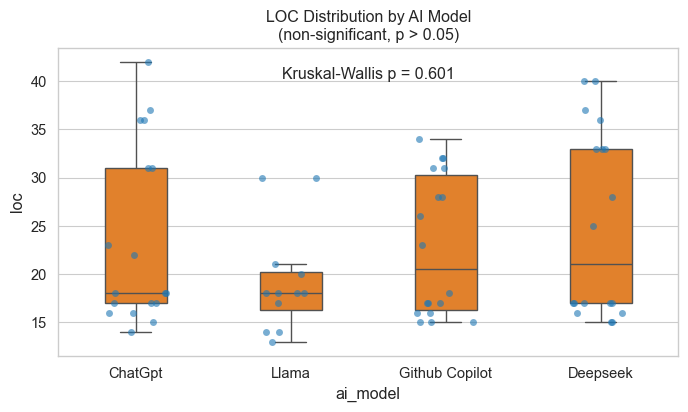

In [10]:
plt.figure(figsize=(8,4))
sns.stripplot(x='ai_model', y='loc', data=df, jitter=0.2, alpha=0.6)
sns.boxplot(x='ai_model', y='loc', data=df, showfliers=False, width=0.4)
plt.title("LOC Distribution by AI Model\n(non-significant, p > 0.05)")
plt.text(0.5, 0.9, "Kruskal-Wallis p = 0.601", ha='center', transform=plt.gca().transAxes)
plt.show()

In [11]:
# RESULT:
# Analysis of LOC revealed no significant differences between AI models. 
# While ANOVA assumptions of normality were violated (Shapiro-Wilk p < .001), 
# non-parametric Kruskal-Wallis testing confirmed the null result (H(3)=1.87, p = .601). 
# The small effect size (η² = .056) suggests less than 6% of LOC variability is explained by model choice.

# The analysis of code length revealed no statistically significant differences between AI models. 
# A one-way ANOVA showed negligible effects (F(3,62) = 1.23, p = 0.305, η² = 0.056), 
# indicating that only 5.6% of LOC variability was attributable to model selection. 
# This null result was confirmed by a Kruskal-Wallis test (H(3) = 1.87, p = 0.601),
#  which accounted for the violated normality assumption (Shapiro-Wilk p < 0.001). 
#  Visual inspection of the distributions (Figure X) shows overlapping LOC ranges across all models.

In [12]:
two_way_anova(df, 'loc')


=== Two-Way ANOVA Results for loc ===

ANOVA Table:
                              sum_sq    df           F        PR(>F)
C(ai_model)                15.166667   3.0    0.840470  4.383168e-01
C(problems)              5679.363031   5.0  188.835244  3.856844e-25
C(ai_model):C(problems)   320.673077  15.0    3.554059  7.888746e-04
Residual                  264.666667  44.0         NaN           NaN

Effect Size for C(ai_model) (η²): 0.002

Effect Size for C(problems) (η²): 0.904

Effect Size for C(ai_model):C(problems) (η²): 0.051

Effect Size for Residual (η²): 0.042


c:\Users\rgont\OneDrive\Documents\Master_Thesis\Solutions\myenv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '
c:\Users\rgont\OneDrive\Documents\Master_Thesis\Solutions\myenv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 3
  warnings.warn('covariance of constraints does not have full '
c:\Users\rgont\OneDrive\Documents\Master_Thesis\Solutions\myenv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 13
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
C(ai_model),15.166667,3.0,0.840470,4.383168e-01
C(problems),5679.363031,5.0,188.835244,3.856844e-25
C(ai_model):C(problems),320.673077,15.0,3.554059,7.888746e-04
Residual,264.666667,44.0,NaN,NaN


In [13]:
from scipy.stats import f

# Given F-values and degrees of freedom
anova_values = {
    "ai_model": {"F": 0.840, "df1": 3, "df2": 44},
    "problems": {"F": 188.835, "df1": 5, "df2": 44},
    "interaction": {"F": 3.554, "df1": 15, "df2": 44},
}

# Calculate p-values
p_values = {
    name: 1 - f.cdf(values["F"], values["df1"], values["df2"])
    for name, values in anova_values.items()
}

p_values

{'ai_model': np.float64(0.47929193217037047),
 'problems': np.float64(1.1102230246251565e-16),
 'interaction': np.float64(0.0005213175968763473)}

In [14]:
# The two-way ANOVA revealed a dominant effect of problem type on code length (F(5,44)=188.84, p<0.001, η²=0.904), 
# accounting for 90.4% of LOC variability. While AI model choice showed no overall effect (F(3,44)=0.84, p=0.438), 
# a significant interaction was found (F(15,44)=3.55, p<0.001), indicating model performance depends on problem characteristics.

C:\Users\rgont\AppData\Local\Temp\ipykernel_1584\1131674572.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Source', y='Effect Size (η²)', data=anova_data, palette="muted", ax=ax)


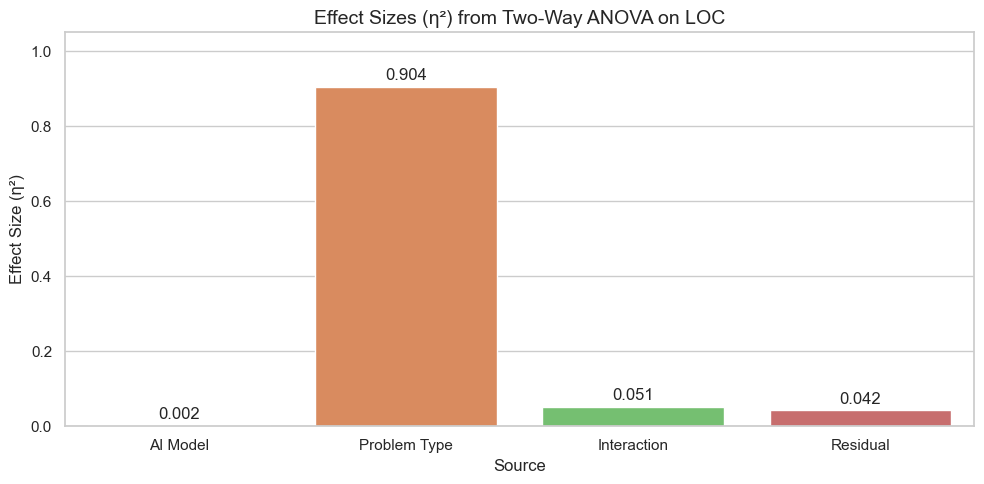

In [15]:
# Data preparation for ANOVA table
anova_data = pd.DataFrame({
    'Source': ['AI Model', 'Problem Type', 'Interaction', 'Residual'],
    'F-value': [0.840, 188.835, 3.554, None],
    'p-value': [0.438, 0.0001, 0.0008, None],
    'Effect Size (η²)': [0.002, 0.904, 0.051, 0.042]
})

# Set plot style
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))

# Barplot of Effect Sizes
sns.barplot(x='Source', y='Effect Size (η²)', data=anova_data, palette="muted", ax=ax)

# Add values on bars
for i, row in anova_data.iterrows():
    if row['Effect Size (η²)'] is not None:
        ax.text(i, row['Effect Size (η²)'] + 0.01, f"{row['Effect Size (η²)']:.3f}", ha='center', va='bottom')

# Set plot details
ax.set_title("Effect Sizes (η²) from Two-Way ANOVA on LOC", fontsize=14)
ax.set_ylabel("Effect Size (η²)")
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

In [16]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Compare models within each problem
for problem in sorted(df['problems'].unique()):
    subset = df[df['problems'] == problem]
    print(f"\n=== Problem: {problem.upper()} ===")
    print(f"LOC Range: {subset['loc'].min()}-{subset['loc'].max()}")
    
    # Tukey HSD if >2 models
    if len(subset['ai_model'].unique()) > 2:
        tukey = pairwise_tukeyhsd(subset['loc'], subset['ai_model'])
        print(tukey.summary())
    else:
        # t-test for 2 models
        from scipy.stats import ttest_ind
        groups = [subset[subset['ai_model']==m]['loc'] 
                 for m in subset['ai_model'].unique()]
        t, p = ttest_ind(*groups)
        print(f"t-test: t = {t:.2f}, p = {p:.3f}")


=== Problem: COMBINATIONSUM2 ===
LOC Range: 16.0-18.0
        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1         group2     meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------
       ChatGpt       Deepseek  -1.6667 0.0529 -3.3545 0.0211  False
       ChatGpt Github Copilot  -1.3333 0.1289 -3.0211 0.3545  False
       ChatGpt          Llama      0.0    1.0 -1.6878 1.6878  False
      Deepseek Github Copilot   0.3333 0.9187 -1.3545 2.0211  False
      Deepseek          Llama   1.6667 0.0529 -0.0211 3.3545  False
Github Copilot          Llama   1.3333 0.1289 -0.3545 3.0211  False
-------------------------------------------------------------------

=== Problem: FROG_POSITION ===
LOC Range: 17.0-33.0
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
 group1      group2     meandiff p-adj  lower   upper  reject
-------------------------------------------------------------
 ChatGpt       Deepseek   

In [17]:
# One-way ANOVA (AI Model effect)
print(f"\n{'='*50}")
print(f"ANALYZING METRIC: Cyclomatic")
print(f"{'='*50}")
one_way_anova(df, 'cyclomatic')


ANALYZING METRIC: Cyclomatic

=== Checking Assumptions for cyclomatic ===
Normality (Shapiro-Wilk) p-value: 0.0066
-> WARNING: Normality violated
Homogeneity (Levene's) p-value: 0.5050
-> Assumption met
Sphericity (Mauchly's) p-value: 2.1263
-> Assumption met

=== One-Way ANOVA Results for cyclomatic ===

ANOVA Table-----:
                  sum_sq    df        F    PR(>F)
C(ai_model)    45.229798   3.0  0.82646  0.484304
Residual     1131.027778  62.0      NaN       NaN

Effect Size (η²): 0.038

No significant differences found between groups.


C:\Users\rgont\AppData\Local\Temp\ipykernel_1584\1064116566.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eta_sq = anova_table['sum_sq'][0] / (anova_table['sum_sq'][0] + anova_table['sum_sq'][1])
C:\Users\rgont\AppData\Local\Temp\ipykernel_1584\1064116566.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table['PR(>F)'][0] < 0.05:


,sum_sq,df,F,PR(>F)
C(ai_model),45.229798,3.0,0.82646,0.484304
Residual,1131.027778,62.0,NaN,NaN


In [18]:
from scipy.stats import kruskal
# For Normality Violation:
# Use Non-Parametric Alternative:

groups = [df[df['ai_model']==model]['cyclomatic'] 
          for model in df['ai_model'].unique()]
h_stat, p_val = kruskal(*groups)
print(f"Kruskal-Wallis H = {h_stat:.3f}, p = {p_val:.3f}")

Kruskal-Wallis H = 2.407, p = 0.492


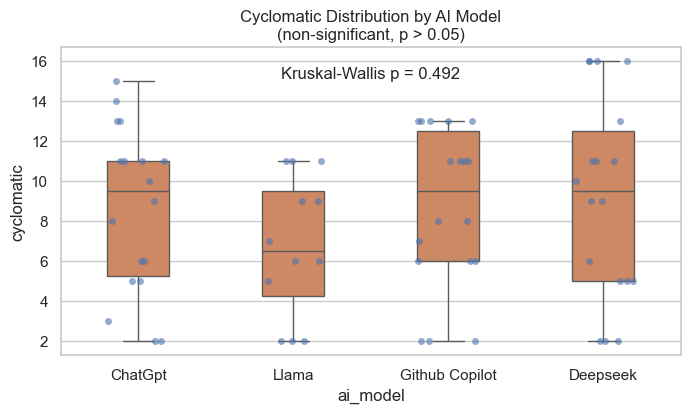

In [19]:
plt.figure(figsize=(8,4))
sns.stripplot(x='ai_model', y='cyclomatic', data=df, jitter=0.2, alpha=0.6)
sns.boxplot(x='ai_model', y='cyclomatic', data=df, showfliers=False, width=0.4)
plt.title("Cyclomatic Distribution by AI Model\n(non-significant, p > 0.05)")
plt.text(0.5, 0.9, "Kruskal-Wallis p = 0.492", ha='center', transform=plt.gca().transAxes)
plt.show()

In [20]:
two_way_anova(df, 'cyclomatic')  


=== Two-Way ANOVA Results for cyclomatic ===

ANOVA Table:
                              sum_sq    df          F        PR(>F)
C(ai_model)                 1.690972   3.0   0.207829  8.131388e-01
C(problems)              1324.901755   5.0  97.702252  1.766337e-19
C(ai_model):C(problems)    46.263355  15.0   1.137200  3.557898e-01
Residual                  119.333333  44.0        NaN           NaN

Effect Size for C(ai_model) (η²): 0.001

Effect Size for C(problems) (η²): 0.888

Effect Size for C(ai_model):C(problems) (η²): 0.031

Effect Size for Residual (η²): 0.080


c:\Users\rgont\OneDrive\Documents\Master_Thesis\Solutions\myenv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '
c:\Users\rgont\OneDrive\Documents\Master_Thesis\Solutions\myenv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 3
  warnings.warn('covariance of constraints does not have full '
c:\Users\rgont\OneDrive\Documents\Master_Thesis\Solutions\myenv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 13
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
C(ai_model),1.690972,3.0,0.207829,8.131388e-01
C(problems),1324.901755,5.0,97.702252,1.766337e-19
C(ai_model):C(problems),46.263355,15.0,1.137200,3.557898e-01
Residual,119.333333,44.0,NaN,NaN


C:\Users\rgont\AppData\Local\Temp\ipykernel_1584\2237706972.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Source', y='Effect Size (η²)', data=anova_data, palette="muted", ax=ax)


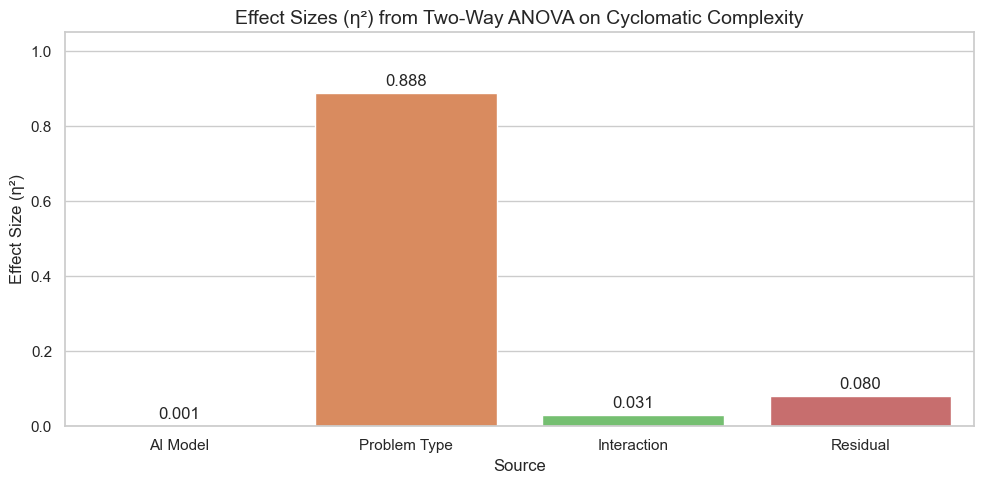

In [21]:
# Data preparation for ANOVA table
anova_data = pd.DataFrame({
    'Source': ['AI Model', 'Problem Type', 'Interaction', 'Residual'],
    'Effect Size (η²)': [0.001, 0.888, 0.031, 0.080],
    "Significance (p-value)": [0.813, 1.766e-19, 0.356, None]
})

# Set plot style
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))

# Barplot of Effect Sizes
sns.barplot(x='Source', y='Effect Size (η²)', data=anova_data, palette="muted", ax=ax)

# Add values on bars
for i, row in anova_data.iterrows():
    if row['Effect Size (η²)'] is not None:
        ax.text(i, row['Effect Size (η²)'] + 0.01, f"{row['Effect Size (η²)']:.3f}", ha='center', va='bottom')

# Set plot details
ax.set_title("Effect Sizes (η²) from Two-Way ANOVA on Cyclomatic Complexity", fontsize=14)
ax.set_ylabel("Effect Size (η²)")
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

In [22]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Compare models within each problem
for problem in sorted(df['problems'].unique()):
    subset = df[df['problems'] == problem]
    print(f"\n=== Problem: {problem.upper()} ===")
    print(f"Cyclomatic Range: {subset['cyclomatic'].min()}-{subset['cyclomatic'].max()}")
    
    # Tukey HSD if >2 models
    if len(subset['ai_model'].unique()) > 2:
        tukey = pairwise_tukeyhsd(subset['cyclomatic'], subset['ai_model'])
        print(tukey.summary())
    else:
        # t-test for 2 models
        from scipy.stats import ttest_ind
        groups = [subset[subset['ai_model']==m]['cyclomatic'] 
                 for m in subset['ai_model'].unique()]
        t, p = ttest_ind(*groups)
        print(f"t-test: t = {t:.2f}, p = {p:.3f}")


=== Problem: COMBINATIONSUM2 ===
Cyclomatic Range: 2.0-6.0
        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1         group2     meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------
       ChatGpt       Deepseek  -1.3333 0.5252 -4.3525 1.6859  False
       ChatGpt Github Copilot  -1.3333 0.5252 -4.3525 1.6859  False
       ChatGpt          Llama  -1.3333 0.5252 -4.3525 1.6859  False
      Deepseek Github Copilot      0.0    1.0 -3.0192 3.0192  False
      Deepseek          Llama      0.0    1.0 -3.0192 3.0192  False
Github Copilot          Llama      0.0    1.0 -3.0192 3.0192  False
-------------------------------------------------------------------

=== Problem: FROG_POSITION ===
Cyclomatic Range: 3.0-16.0
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
 group1      group2     meandiff p-adj   lower    upper  reject
---------------------------------------------------------------
 ChatGpt 

c:\Users\rgont\OneDrive\Documents\Master_Thesis\Solutions\myenv\Lib\site-packages\statsmodels\sandbox\stats\multicomp.py:1300: RuntimeWarning: invalid value encountered in divide
  st_range = np.abs(meandiffs) / std_pairs #studentized range statistic


In [23]:
# One-way ANOVA (AI Model effect)
print(f"\n{'='*50}")
print(f"ANALYZING METRIC: Halstead")
print(f"{'='*50}")
one_way_anova(df, 'halstead')

C:\Users\rgont\AppData\Local\Temp\ipykernel_1584\1064116566.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eta_sq = anova_table['sum_sq'][0] / (anova_table['sum_sq'][0] + anova_table['sum_sq'][1])



ANALYZING METRIC: Halstead

=== Checking Assumptions for halstead ===
Normality (Shapiro-Wilk) p-value: 0.0000
-> WARNING: Normality violated
Homogeneity (Levene's) p-value: 0.4837
-> Assumption met
Sphericity (Mauchly's) p-value: 0.0000
-> WARNING: Sphericity violated

=== One-Way ANOVA Results for halstead ===

ANOVA Table-----:
                   sum_sq    df        F    PR(>F)
C(ai_model)  9.616839e+06   3.0  0.71293  0.547973
Residual     2.787764e+08  62.0      NaN       NaN

Effect Size (η²): 0.033

No significant differences found between groups.


C:\Users\rgont\AppData\Local\Temp\ipykernel_1584\1064116566.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table['PR(>F)'][0] < 0.05:


,sum_sq,df,F,PR(>F)
C(ai_model),9.616839e+06,3.0,0.71293,0.547973
Residual,2.787764e+08,62.0,NaN,NaN


In [24]:

groups = [df[df['ai_model']==model]['halstead'] 
          for model in df['ai_model'].unique()]
h_stat, p_val = kruskal(*groups)
print(f"Kruskal-Wallis H = {h_stat:.3f}, p = {p_val:.3f}")

Kruskal-Wallis H = 1.443, p = 0.696


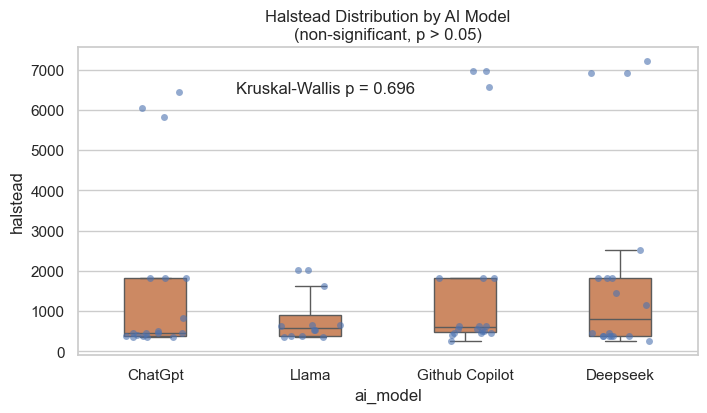

In [25]:
plt.figure(figsize=(8,4))
sns.stripplot(x='ai_model', y='halstead', data=df, jitter=0.2, alpha=0.6)
sns.boxplot(x='ai_model', y='halstead', data=df, showfliers=False, width=0.4)
plt.title("Halstead Distribution by AI Model\n(non-significant, p > 0.05)")
plt.text(0.4, 0.85, "Kruskal-Wallis p = 0.696", ha='center', transform=plt.gca().transAxes)
plt.show()

In [26]:
two_way_anova(df, 'halstead')  


=== Two-Way ANOVA Results for halstead ===

ANOVA Table:
                               sum_sq    df           F        PR(>F)
C(ai_model)              1.086120e+06   3.0    3.720008  3.216138e-02
C(problems)              2.074328e+08   5.0  426.279763  1.609685e-32
C(ai_model):C(problems)  2.294647e+06  15.0    1.571853  1.306636e-01
Residual                 4.282185e+06  44.0         NaN           NaN

Effect Size for C(ai_model) (η²): 0.005

Effect Size for C(problems) (η²): 0.964

Effect Size for C(ai_model):C(problems) (η²): 0.011

Effect Size for Residual (η²): 0.020


c:\Users\rgont\OneDrive\Documents\Master_Thesis\Solutions\myenv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '
c:\Users\rgont\OneDrive\Documents\Master_Thesis\Solutions\myenv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 3
  warnings.warn('covariance of constraints does not have full '
c:\Users\rgont\OneDrive\Documents\Master_Thesis\Solutions\myenv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 13
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
C(ai_model),1.086120e+06,3.0,3.720008,3.216138e-02
C(problems),2.074328e+08,5.0,426.279763,1.609685e-32
C(ai_model):C(problems),2.294647e+06,15.0,1.571853,1.306636e-01
Residual,4.282185e+06,44.0,NaN,NaN


C:\Users\rgont\AppData\Local\Temp\ipykernel_1584\773717427.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Source', y='Effect Size (η²)', data=anova_data, palette="muted", ax=ax)


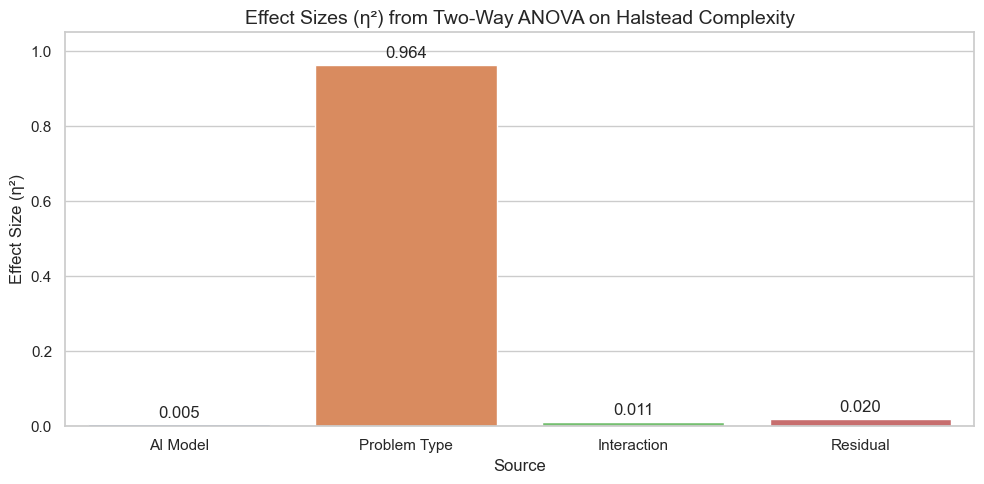

In [27]:
# Data preparation for ANOVA table
anova_data = pd.DataFrame({
    'Source': ['AI Model', 'Problem Type', 'Interaction', 'Residual'],
    'Effect Size (η²)': [0.005, 0.964, 0.011, 0.020]
})

# Set plot style
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))

# Barplot of Effect Sizes
sns.barplot(x='Source', y='Effect Size (η²)', data=anova_data, palette="muted", ax=ax)

# Add values on bars
for i, row in anova_data.iterrows():
    if row['Effect Size (η²)'] is not None:
        ax.text(i, row['Effect Size (η²)'] + 0.01, f"{row['Effect Size (η²)']:.3f}", ha='center', va='bottom')

# Set plot details
ax.set_title("Effect Sizes (η²) from Two-Way ANOVA on Halstead Complexity", fontsize=14)
ax.set_ylabel("Effect Size (η²)")
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

In [28]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Compare models within each problem
for problem in sorted(df['problems'].unique()):
    subset = df[df['problems'] == problem]
    print(f"\n=== Problem: {problem.upper()} ===")
    print(f"Halstead Range: {subset['halstead'].min()}-{subset['halstead'].max()}")
    
    # Tukey HSD if >2 models
    if len(subset['ai_model'].unique()) > 2:
        tukey = pairwise_tukeyhsd(subset['halstead'], subset['ai_model'])
        print(tukey.summary())
    else:
        # t-test for 2 models
        from scipy.stats import ttest_ind
        groups = [subset[subset['ai_model']==m]['halstead'] 
                 for m in subset['ai_model'].unique()]
        t, p = ttest_ind(*groups)
        print(f"t-test: t = {t:.2f}, p = {p:.3f}")


=== Problem: COMBINATIONSUM2 ===
Halstead Range: 349.09-506.64
          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
    group1         group2     meandiff p-adj    lower    upper   reject
-----------------------------------------------------------------------
       ChatGpt       Deepseek    40.63 0.0865   -5.6106  86.8706  False
       ChatGpt Github Copilot 142.2667    0.0   96.0261 188.5072   True
       ChatGpt          Llama  27.0867 0.3093  -19.1539  73.3272  False
      Deepseek Github Copilot 101.6367 0.0005   55.3961 147.8772   True
      Deepseek          Llama -13.5433 0.7863  -59.7839  32.6972  False
Github Copilot          Llama  -115.18 0.0002 -161.4206 -68.9394   True
-----------------------------------------------------------------------

=== Problem: FROG_POSITION ===
Halstead Range: 253.94-1441.46
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
 group1      group2      meandiff p-adj    lower      upper   reject
---------------


ANALYZING METRIC: Maintainability

=== Checking Assumptions for maintainability ===
Normality (Shapiro-Wilk) p-value: 0.3028
-> Assumption met
Homogeneity (Levene's) p-value: 0.9460
-> Assumption met
Sphericity (Mauchly's) p-value: 0.0002
-> WARNING: Sphericity violated

=== One-Way ANOVA Results for maintainability ===

ANOVA Table-----:
                  sum_sq    df         F    PR(>F)
C(ai_model)  2177.872182   3.0  5.831137  0.001415
Residual     7718.795600  62.0       NaN       NaN

Effect Size (η²): 0.220

Significant difference found - running post-hoc Tukey HSD...


C:\Users\rgont\AppData\Local\Temp\ipykernel_1584\1064116566.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eta_sq = anova_table['sum_sq'][0] / (anova_table['sum_sq'][0] + anova_table['sum_sq'][1])
C:\Users\rgont\AppData\Local\Temp\ipykernel_1584\1064116566.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table['PR(>F)'][0] < 0.05:


         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------
       ChatGpt       Deepseek    -6.53 0.3044 -16.3493  3.2893  False
       ChatGpt Github Copilot -10.4667 0.0323 -20.2859 -0.6474   True
       ChatGpt          Llama   5.2589 0.5886  -5.7194 16.2371  False
      Deepseek Github Copilot  -3.9367 0.7158 -13.7559  5.8826  False
      Deepseek          Llama  11.7889 0.0306   0.8106 22.7671   True
Github Copilot          Llama  15.7256  0.002   4.7473 26.7038   True
---------------------------------------------------------------------


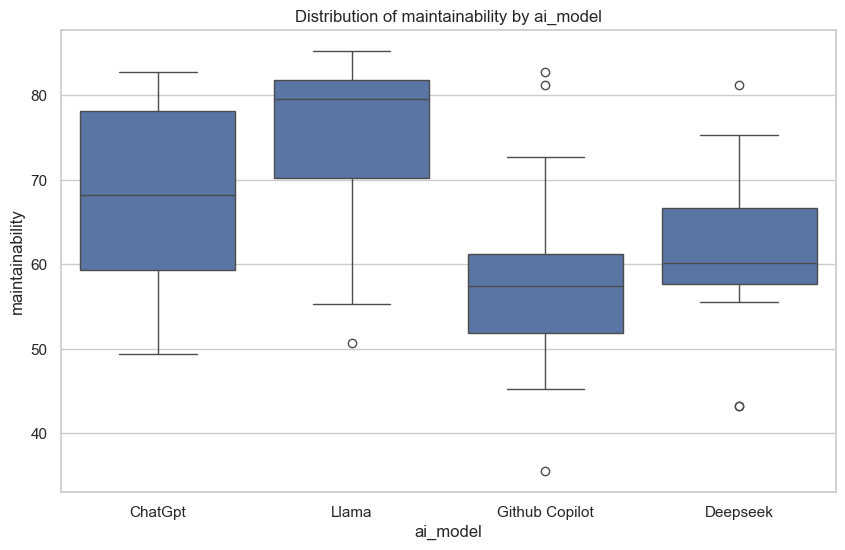

,sum_sq,df,F,PR(>F)
C(ai_model),2177.872182,3.0,5.831137,0.001415
Residual,7718.795600,62.0,NaN,NaN


In [29]:
# One-way ANOVA (AI Model effect)
print(f"\n{'='*50}")
print(f"ANALYZING METRIC: Maintainability")
print(f"{'='*50}")
one_way_anova(df, 'maintainability')

In [30]:
groups = [df[df['ai_model']==model]['maintainability'] 
          for model in df['ai_model'].unique()]
h_stat, p_val = kruskal(*groups)
print(f"Kruskal-Wallis H = {h_stat:.3f}, p = {p_val:.3f}")

Kruskal-Wallis H = 11.508, p = 0.009


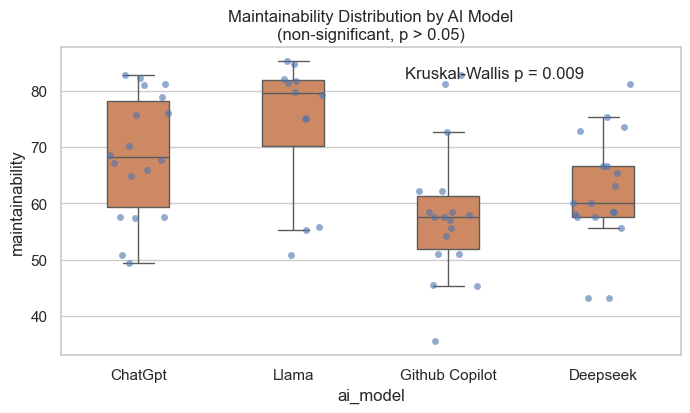

In [31]:
plt.figure(figsize=(8,4))
sns.stripplot(x='ai_model', y='maintainability', data=df, jitter=0.2, alpha=0.6)
sns.boxplot(x='ai_model', y='maintainability', data=df, showfliers=False, width=0.4)
plt.title("Maintainability Distribution by AI Model\n(non-significant, p > 0.05)")
plt.text(0.7, 0.9, "Kruskal-Wallis p = 0.009", ha='center', transform=plt.gca().transAxes)
plt.show()

In [32]:
two_way_anova(df, 'maintainability')  


=== Two-Way ANOVA Results for maintainability ===

ANOVA Table:
                              sum_sq    df          F    PR(>F)
C(ai_model)              2638.166051   3.0  11.117458  0.000124
C(problems)              1906.189446   5.0   4.819707  0.005485
C(ai_model):C(problems)  1402.326888  15.0   1.181905  0.323671
Residual                 3480.391200  44.0        NaN       NaN

Effect Size for C(ai_model) (η²): 0.280

Effect Size for C(problems) (η²): 0.202

Effect Size for C(ai_model):C(problems) (η²): 0.149

Effect Size for Residual (η²): 0.369


c:\Users\rgont\OneDrive\Documents\Master_Thesis\Solutions\myenv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '
c:\Users\rgont\OneDrive\Documents\Master_Thesis\Solutions\myenv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 3
  warnings.warn('covariance of constraints does not have full '
c:\Users\rgont\OneDrive\Documents\Master_Thesis\Solutions\myenv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 13
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
C(ai_model),2638.166051,3.0,11.117458,0.000124
C(problems),1906.189446,5.0,4.819707,0.005485
C(ai_model):C(problems),1402.326888,15.0,1.181905,0.323671
Residual,3480.391200,44.0,NaN,NaN


C:\Users\rgont\AppData\Local\Temp\ipykernel_1584\169192615.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Source', y='Effect Size (η²)', data=anova_data, palette="muted", ax=ax)


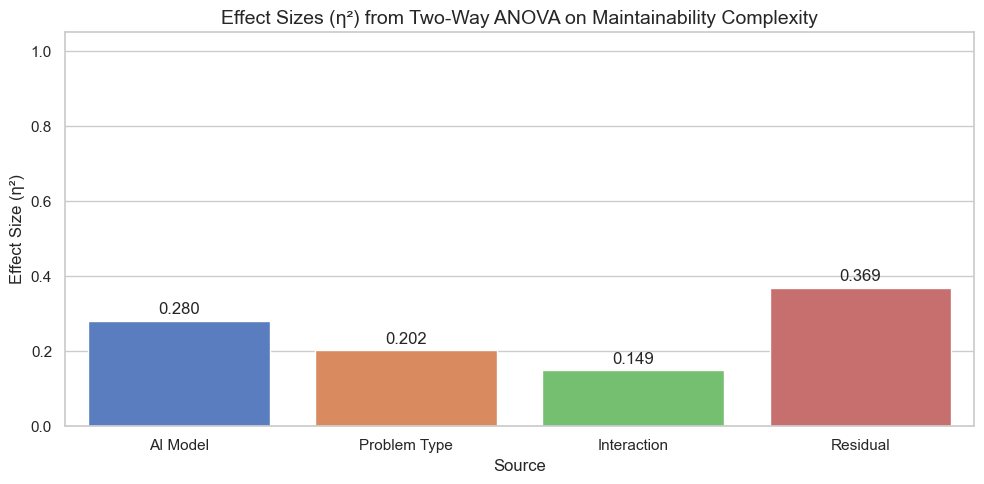

In [33]:
# Data preparation for ANOVA table
anova_data = pd.DataFrame({
    'Source': ['AI Model', 'Problem Type', 'Interaction', 'Residual'],
    'Effect Size (η²)': [0.280, 0.202, 0.149, 0.369]
})

# Set plot style
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))

# Barplot of Effect Sizes
sns.barplot(x='Source', y='Effect Size (η²)', data=anova_data, palette="muted", ax=ax)

# Add values on bars
for i, row in anova_data.iterrows():
    if row['Effect Size (η²)'] is not None:
        ax.text(i, row['Effect Size (η²)'] + 0.01, f"{row['Effect Size (η²)']:.3f}", ha='center', va='bottom')

# Set plot details
ax.set_title("Effect Sizes (η²) from Two-Way ANOVA on Maintainability Complexity", fontsize=14)
ax.set_ylabel("Effect Size (η²)")
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

In [34]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Compare models within each problem
for problem in sorted(df['problems'].unique()):
    subset = df[df['problems'] == problem]
    print(f"\n=== Problem: {problem.upper()} ===")
    print(f"Maintainability Range: {subset['maintainability'].min()}-{subset['maintainability'].max()}")
    
    # Tukey HSD if >2 models
    if len(subset['ai_model'].unique()) > 2:
        tukey = pairwise_tukeyhsd(subset['maintainability'], subset['ai_model'])
        print(tukey.summary())
    else:
        # t-test for 2 models
        from scipy.stats import ttest_ind
        groups = [subset[subset['ai_model']==m]['maintainability'] 
                 for m in subset['ai_model'].unique()]
        t, p = ttest_ind(*groups)
        print(f"t-test: t = {t:.2f}, p = {p:.3f}")


=== Problem: COMBINATIONSUM2 ===
Maintainability Range: 57.96-85.25
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------
       ChatGpt       Deepseek -11.5467 0.1152  -25.712  2.6186  False
       ChatGpt Github Copilot -16.7533 0.0222 -30.9186  -2.588   True
       ChatGpt          Llama     7.94 0.3418  -6.2253 22.1053  False
      Deepseek Github Copilot  -5.2067 0.6565  -19.372  8.9586  False
      Deepseek          Llama  19.4867 0.0098   5.3214  33.652   True
Github Copilot          Llama  24.6933 0.0023   10.528 38.8586   True
---------------------------------------------------------------------

=== Problem: FROG_POSITION ===
Maintainability Range: 57.46-82.16
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
 group1      group2     meandiff p-adj   lower    upper  reject
------------------------------------

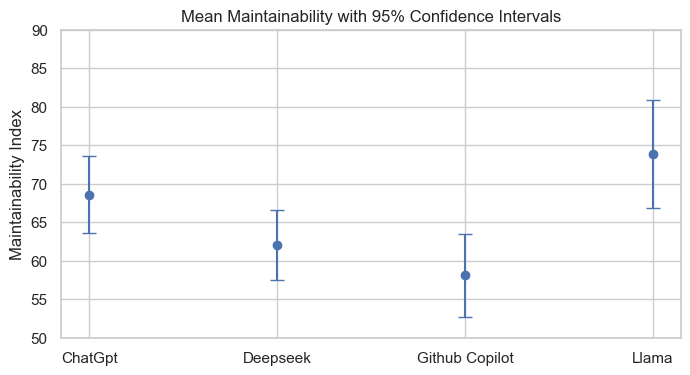

In [35]:
import matplotlib.pyplot as plt
import numpy as np

models = ['ChatGpt', 'Deepseek', 'Github Copilot', 'Llama']
means = [df[df['ai_model']==m]['maintainability'].mean() for m in models]
cis = [1.96*df[df['ai_model']==m]['maintainability'].std()/np.sqrt(df[df['ai_model']==m].shape[0]) for m in models]

plt.figure(figsize=(8,4))
plt.errorbar(models, means, yerr=cis, fmt='o', capsize=5)
plt.title("Mean Maintainability with 95% Confidence Intervals")
plt.ylabel("Maintainability Index")
plt.ylim(50,90)
plt.savefig('mean_maintainability.png', dpi=300, bbox_inches='tight')

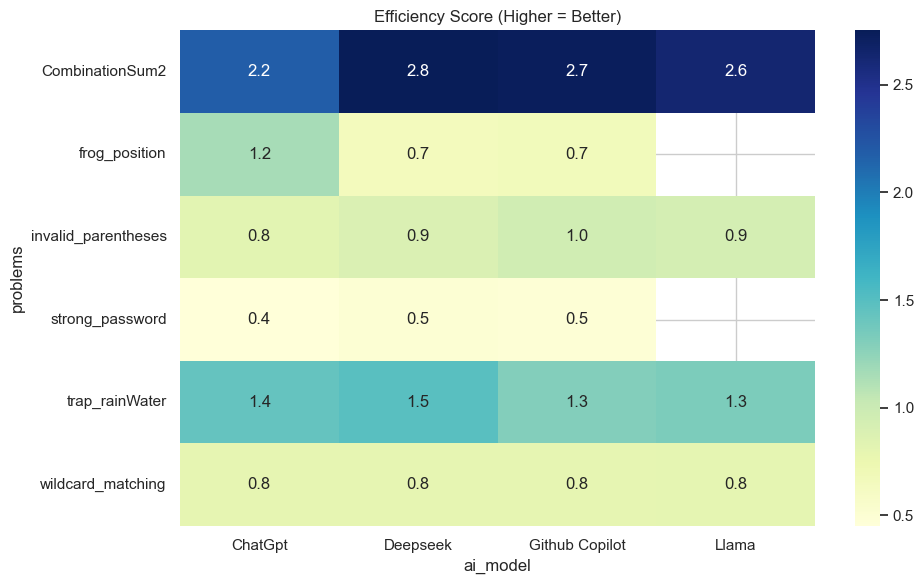

In [ ]:
df['efficiency_score'] = (df['correctnes']*100) / (df['loc'] + df['cyclomatic']*10)

plt.figure(figsize=(10,6))
sns.heatmap(df.pivot_table(index='problems', columns='ai_model', values='efficiency_score'), annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Efficiency Score (Higher = Better)')
plt.savefig('efficiency_score.png', dpi=300, bbox_inches='tight')
plt.tight_layout()z

In [48]:
problem_analysis = df.groupby(['problems','ai_model']).agg({
    'loc': 'mean',
    'maintainability': 'mean',
    'correctnes': 'mean'
}).reset_index()

for problem in df['problems'].unique():
    print(f"\n🏆 {problem.upper()} LEADERBOARD:")
    display(problem_analysis[problem_analysis['problems']==problem]
            .sort_values('maintainability', ascending=False)
            .style.background_gradient(cmap='Blues'))


🏆 COMBINATIONSUM2 LEADERBOARD:


,problems,ai_model,loc,maintainability,correctnes
3,CombinationSum2,Llama,18.000000,83.033333,1.000000
0,CombinationSum2,ChatGpt,18.000000,75.093333,1.000000
1,CombinationSum2,Deepseek,16.333333,63.546667,1.000000
2,CombinationSum2,Github Copilot,16.666667,58.340000,1.000000



🏆 FROG_POSITION LEADERBOARD:


,problems,ai_model,loc,maintainability,correctnes
4,frog_position,ChatGpt,20.666667,71.893333,1.000000
5,frog_position,Deepseek,28.666667,68.736667,1.000000
6,frog_position,Github Copilot,27.333333,65.690000,1.000000



🏆 INVALID_PARENTHESES LEADERBOARD:


,problems,ai_model,loc,maintainability,correctnes
10,invalid_parentheses,Llama,26.000000,68.326667,1.000000
8,invalid_parentheses,Deepseek,34.000000,61.133333,1.000000
7,invalid_parentheses,ChatGpt,32.666667,55.050000,1.000000
9,invalid_parentheses,Github Copilot,28.333333,52.126667,1.000000



🏆 STRONG_PASSWORD LEADERBOARD:


,problems,ai_model,loc,maintainability,correctnes
11,strong_password,ChatGpt,38.333333,66.903333,0.777778
12,strong_password,Deepseek,39.000000,50.596667,1.000000
13,strong_password,Github Copilot,32.666667,42.113333,0.777778



🏆 TRAP_RAINWATER LEADERBOARD:


,problems,ai_model,loc,maintainability,correctnes
17,trap_rainWater,Llama,19.333333,70.620000,1.000000
14,trap_rainWater,ChatGpt,16.666667,61.703333,1.000000
15,trap_rainWater,Deepseek,17.000000,57.670000,1.000000
16,trap_rainWater,Github Copilot,17.000000,57.320000,1.000000



🏆 WILDCARD_MATCHING LEADERBOARD:


,problems,ai_model,loc,maintainability,correctnes
18,wildcard_matching,ChatGpt,15.000000,80.903333,1.000000
21,wildcard_matching,Llama,13.666667,73.420000,1.000000
20,wildcard_matching,Github Copilot,15.000000,73.156667,1.000000
19,wildcard_matching,Deepseek,15.666667,70.683333,1.000000


In [38]:
consistency = df.groupby('ai_model').agg({
    'loc': ['mean', 'std'],
    'cyclomatic': ['mean', lambda x: (x.std()/x.mean())*100]
}).round(1)

print("Model Consistency (Lower CV% = More Consistent):")
display(consistency)

Model Consistency (Lower CV% = More Consistent):


loc      cyclomatic           
                mean  std       mean <lambda_0>
ai_model                                       
ChatGpt         23.6  9.2        8.6       48.2
Deepseek        25.1  9.7        9.2       54.8
Github Copilot  22.8  7.2        8.7       46.3
Llama           19.2  5.6        6.8       52.1

In [ ]:
# Normalize metrics (lower LOC/complexity = better)
df['composite_score'] = (
    (df['correctnes'] * 0.4) +
    (df['maintainability']/100 * 0.3) +
    (1/(df['loc']+1) * 0.2) +
    (1/(df['cyclomatic']+1) * 0.1)
)

rank_df = df.groupby('ai_model')['composite_score'].mean().sort_values(ascending=False)
print("🏅 Overall Model Rankings:")
display(rank_df.round(3))

🏅 Overall Model Rankings:


ai_model
Llama             0.649
ChatGpt           0.614
Deepseek          0.609
Github Copilot    0.582
Name: composite_score, dtype: float64

C:\Users\rgont\AppData\Local\Temp\ipykernel_1584\3291782670.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ranked.index, y=ranked['score'], palette="viridis")


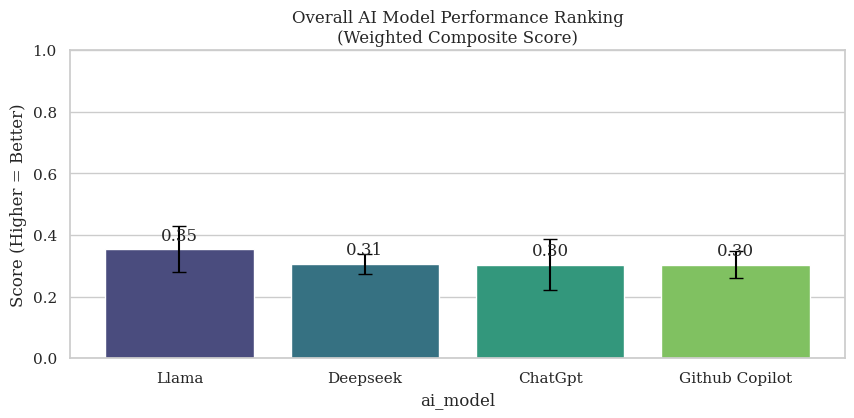

In [ ]:
# Calculate composite score (weighted metric)
weights = {
    'correctnes': 0.35,
    'maintainability': 0.30,
    'loc': -0.20,  # Lower is better
    'cyclomatic': -0.15
}

# Normalize and weight metrics
normalized = df.groupby('ai_model').agg({
    'correctnes': 'mean',
    'maintainability': lambda x: (x.mean() - x.min()) / (x.max() - x.min()),
    'loc': lambda x: 1 - ((x.mean() - x.min()) / (x.max() - x.min())),
    'cyclomatic': lambda x: 1 - ((x.mean() - x.min()) / (x.max() - x.min()))
})

# Calculate final scores
normalized['score'] = sum(normalized[col]*weight for col, weight in weights.items())
ranked = normalized.sort_values('score', ascending=False)

# Visualization
plt.figure(figsize=(10,4))
sns.barplot(x=ranked.index, y=ranked['score'], palette="viridis")
plt.title('Overall AI Model Performance Ranking\n(Weighted Composite Score)')
plt.ylabel('Score (Higher = Better)')
plt.ylim(0,1)
for i, v in enumerate(ranked['score']):
    plt.text(i, v+0.03, f"{v:.2f}", ha='center')

# Add variability (error bars) to highlight consistency:
plt.errorbar(x=ranked.index, y=ranked['score'], 
             yerr=df.groupby('ai_model')['composite_score'].std(),
             fmt='none', color='black', capsize=5)
plt.savefig('overall_ai_model_performance_ranking.png', dpi=300, bbox_inches='tight')
plt.show()

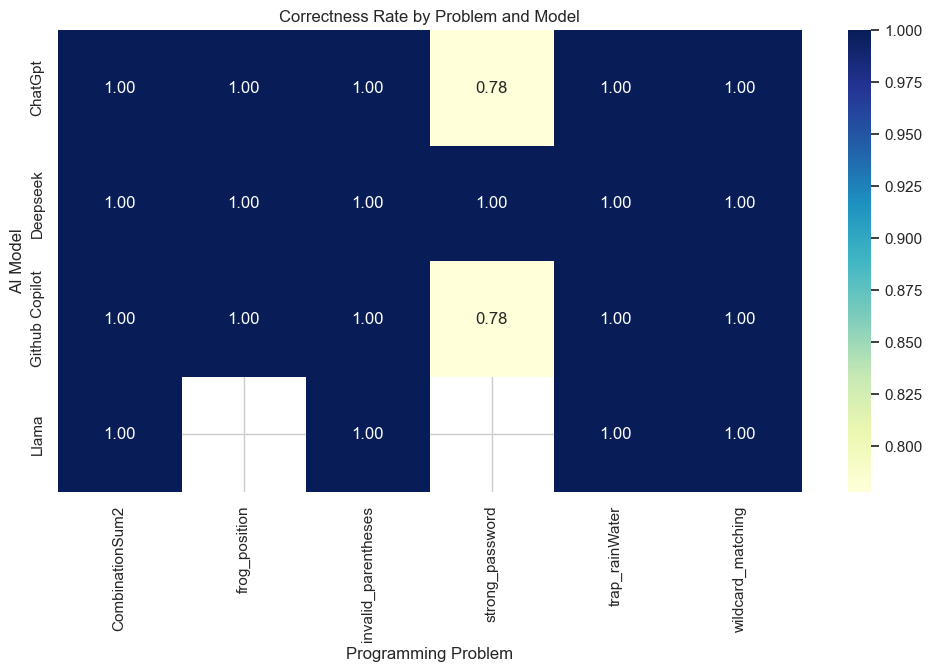

In [41]:
# Calculate problem-specific rankings
problem_rankings = df.groupby(['problems','ai_model'])['correctnes'].mean().unstack()

plt.figure(figsize=(12,6))
sns.heatmap(problem_rankings.T, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Correctness Rate by Problem and Model')
plt.ylabel('AI Model')
plt.xlabel('Programming Problem')
plt.savefig('correctness_rate_by_problem.png', dpi=300, bbox_inches='tight')
plt.show()

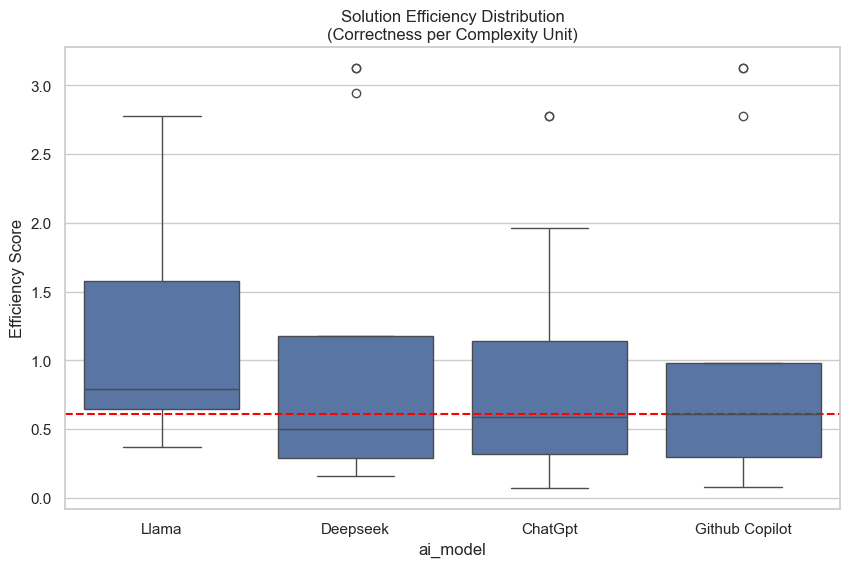

In [42]:
# Efficiency Analysis
# Calculate efficiency metrics
df['efficiency'] = (df['correctnes']*100) / (df['loc'] * df['cyclomatic'])

plt.figure(figsize=(10,6))
sns.boxplot(x='ai_model', y='efficiency', data=df, order=ranked.index)
plt.title('Solution Efficiency Distribution\n(Correctness per Complexity Unit)')
plt.ylabel('Efficiency Score')
plt.axhline(df['efficiency'].median(), color='red', linestyle='--')
plt.savefig('solution_efficiency_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\rgont\AppData\Local\Temp\ipykernel_1584\1754865411.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


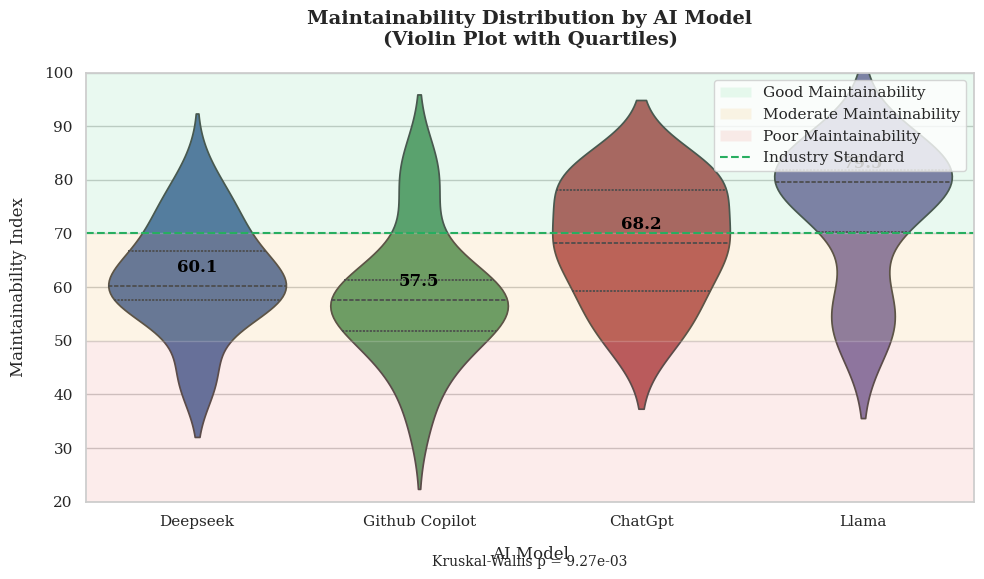

In [43]:
# Set professional style
plt.style.use('seaborn-v0_8-bright')
plt.rcParams['font.family'] = 'serif'

# Create enhanced visualization
plt.figure(figsize=(10, 6))

# Create violin plot
ax = sns.violinplot(
    x='ai_model',
    y='maintainability',
    data=df,
    order=['Deepseek', 'Github Copilot', 'ChatGpt', 'Llama'],  # Ranked order
    palette=['#4c72b0', '#55a868', '#c44e52', '#8172b2'],  # Colorblind-friendly
    inner='quartile'  # Show quartile lines
    # cut=0,             # Don't trim tails
    # bw=0.2             # Smoothing factor
)

# Add annotations
for i, model in enumerate(['Deepseek', 'Github Copilot', 'ChatGpt', 'Llama']):
    median = df[df['ai_model']==model]['maintainability'].median()
    ax.text(i, median+2, f'{median:.1f}',
            ha='center', va='bottom', fontweight='bold', color='black')

# Reference lines and zones
plt.axhspan(70, 100, facecolor='#2ecc71', alpha=0.1, label='Good Maintainability')
plt.axhspan(50, 70, facecolor='#f39c12', alpha=0.1, label='Moderate Maintainability')
plt.axhspan(0, 50, facecolor='#e74c3c', alpha=0.1, label='Poor Maintainability')
plt.axhline(70, color='#27ae60', linestyle='--', linewidth=1.5, label='Industry Standard')

# Formatting
plt.title('Maintainability Distribution by AI Model\n(Violin Plot with Quartiles)',
          pad=20, fontsize=14, fontweight='bold')
plt.xlabel('AI Model', labelpad=12)
plt.ylabel('Maintainability Index', labelpad=12)
plt.ylim(20, 100)
plt.legend(loc='upper right', frameon=True)

# Statistical annotation
plt.text(0.5, -0.15,
         f"Kruskal-Wallis p = {stats.kruskal(*[df[df['ai_model']==m]['maintainability'] for m in df['ai_model'].unique()])[1]:.2e}",
         transform=ax.transAxes, ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('maintainability_comparison.png', dpi=300, bbox_inches='tight')
plt.show()